
1.

Proszę pobrać zbiór fasion MNIST (torchvision.datasets.FashionMNIST) i zaproponować sieć konwolucyjną do jego klasyfikacji. Dla co najmniej trzech architektur proszę wypisać macierz pomyłek i wykresy funkcji strat podczas uczenia. Proszę spróbować w każdym wypadku podać przynajmniej jeden źle zaklasyfikowany obrazek.

_Proszę pamiętać, że zadanie może wymagać odpowiedniego czasu na obliczenia. Nie polecamy wykonywać go na komputerach uczelnianych, tylko wykorzystać zasoby colaba (albo własne, jeśli państwo chcą). Ewentualne przyśpieszenie obliczeń można uzyskać korzystając z GPU w colabie, jeżeli nie dysponują państwo kartą NVidii albo nie chcą jej państwo używać (opisane w zadaniu 2*)_

In [ ]:
%pip install torch torchvision torchaudio


In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np

In [9]:



data = datasets.FashionMNIST('data', download=True, train=True, transform=transforms.ToTensor())



100.0%


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100.0%


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100.0%


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100.0%

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [22]:
test_data = datasets.FashionMNIST('data', download=True, train=False, transform=transforms.ToTensor())

In [21]:
print(type(data.data))
print(data.data.shape)
data.data.dtype


<class 'torch.Tensor'>
torch.Size([60000, 28, 28])


torch.uint8

In [31]:
transform = transforms.Compose( [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))] )

#prepare for validation
indexes = list(range(len(data)))
np.random.shuffle(indexes)
split = int(np.floor(0.2 * len(data)))
trainSampler = SubsetRandomSampler(indexes[:split])
validSampler = SubsetRandomSampler(indexes[split:])




In [32]:
#load data
trainLoader = torch.utils.data.DataLoader(data, batch_size=64, sampler=trainSampler)
validLoader = torch.utils.data.DataLoader(data, batch_size=64, sampler=validSampler)
testLoader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=True)


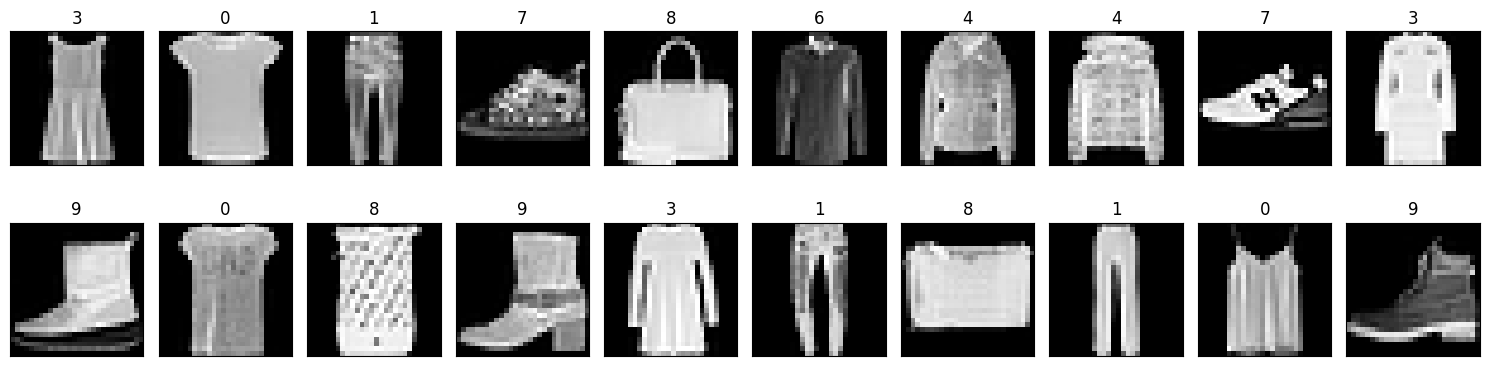

In [35]:
#print data
import matplotlib.pyplot as plt

i = iter(trainLoader)
images, labels = next(i)


fig = plt.figure(figsize=(15, 5))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    ax.imshow(images[idx].numpy().squeeze(), cmap='gray')
    ax.set_title(str(labels[idx].item()))
    fig.tight_layout()


In [68]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Conv2d(1, 32, 3, 1)
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = F.conv2d(self.fc5(x))
        x = self.dropout(x)
        x = F.log_softmax(self.fc4(x), dim=1)
        return x
    
    


In [69]:
model = Classifier()

criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

valid_loss_min = np.Inf
epochs = 30
steps = 0
model.train()
train_losses, valid_losses = [], []
for e in range(epochs):
    running_loss = 0
    valid_loss = 0
    for images, labels in trainLoader:
        optimizer.zero_grad()
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()*images.size(0)
    
    for images, labels in validLoader:
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        valid_loss += loss.item()*images.size(0)
        
    running_loss = running_loss/len(trainLoader.sampler)
    valid_loss = valid_loss/len(validLoader.sampler)
    train_losses.append(running_loss)
    valid_losses.append(valid_loss)
    
    print(f'Epoch: {e+1} \tTraining Loss: {round(running_loss,4)} \tValidation Loss: {round(valid_loss,4)}'.format())
    
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min, valid_loss))
        torch.save(model.state_dict(), 'model.pt')
        valid_loss_min = valid_loss
        


RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [64, 64]

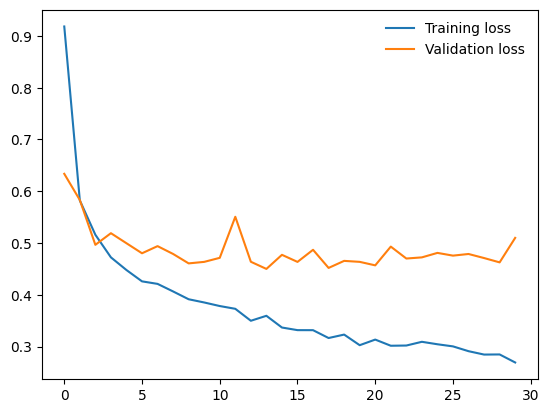

In [45]:
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.legend(frameon=False)

In [46]:
test_loss = 0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
for images, labels in testLoader:
    output = model(images)
    loss = criterion(output, labels)
    test_loss += loss.item()*images.size(0)
    _, pred = torch.max(output, 1)
    correct = np.squeeze(pred.eq(labels.data.view_as(pred)))
    for i in range(len(labels)):
        label = labels.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
        
test_loss = test_loss/len(testLoader.dataset)
print('Test Loss: {:.6f}'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))

Test Loss: 0.478099
Test Accuracy of     0: 82% (822/1000)
Test Accuracy of     1: 95% (951/1000)
Test Accuracy of     2: 77% (773/1000)
Test Accuracy of     3: 82% (824/1000)
Test Accuracy of     4: 69% (690/1000)
Test Accuracy of     5: 93% (935/1000)
Test Accuracy of     6: 70% (708/1000)
Test Accuracy of     7: 94% (945/1000)
Test Accuracy of     8: 96% (964/1000)
Test Accuracy of     9: 94% (947/1000)


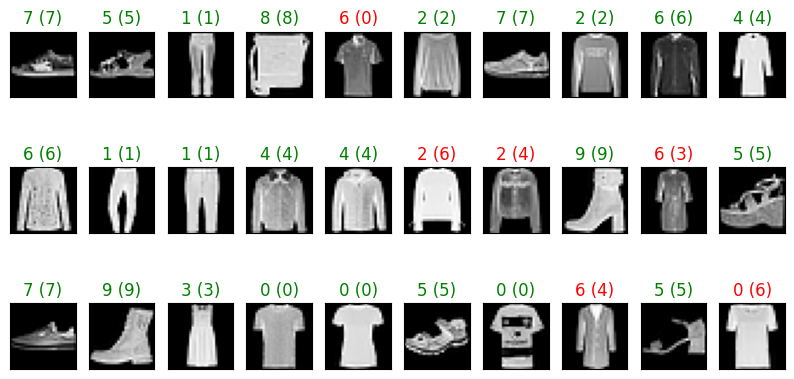

In [58]:
dataiter = iter(testLoader)
images, labels = next(dataiter)

output = model(images)
_, preds = torch.max(output, 1)
images = images.numpy()

fig = plt.figure(figsize=(10, 5))
for idx in np.arange(30):
    ax = fig.add_subplot(3, 10, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                    color=("green" if preds[idx]==labels[idx] else "red"))
    